In [0]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cuongtrinh3005","key":"e76edc96a74f4e1f6080629425a44fde"}'}

In [0]:
# Install Kaggle API
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [0]:
# Download chest x-ray dataset from Kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:28<00:00, 33.2MB/s]
100% 2.29G/2.29G [00:28<00:00, 85.2MB/s]


In [0]:
# unzip the dataset
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: ches

In [0]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning libraries
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from keras.layers import Input

from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

Using TensorFlow backend.


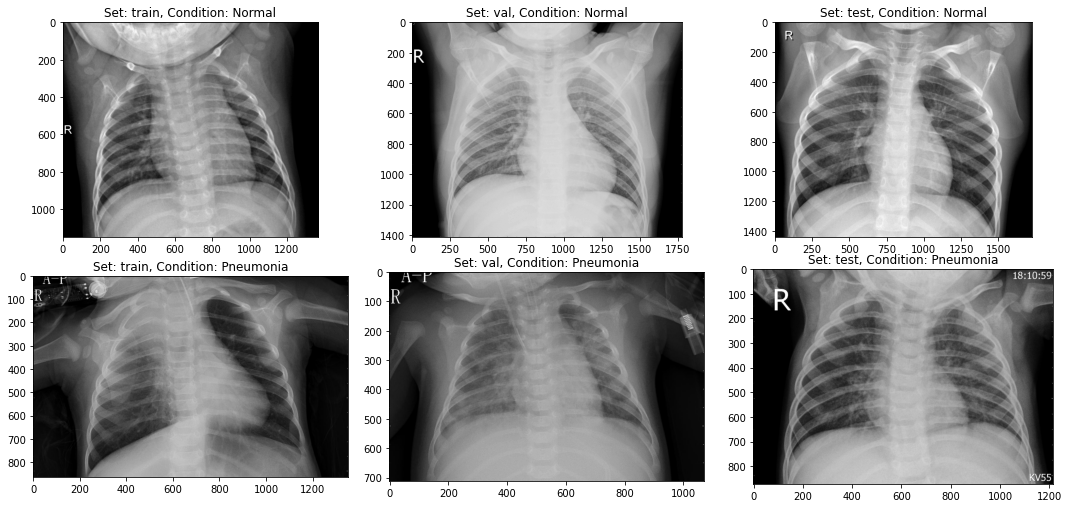

In [0]:
input_path = '/content/chest_xray/chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [0]:
# Distribution of our datasets
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Folder: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Folder: train, normal images: 1342, pneumonia images: 3876
Folder: val, normal images: 9, pneumonia images: 9
Folder: test, normal images: 234, pneumonia images: 390


In [0]:
rescale = 1./255.0
target_size = (224, 224)
img_dims = 224
batch_size = 32
class_mode = 'binary'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    directory=input_path+'train',
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    directory=input_path+'val',
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    directory=input_path+'test',
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

# We will be making predictions off of the test set in one batch size
# This is useful to be able to get the confusion matrix
test_data = []
test_labels = []
path_images = []

for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(input_path + 'test' + cond)):
      if img != '.DS_Store':
          path_img = input_path+'test'+cond+img
          img = plt.imread(path_img)
          path_images.append(path_img)
          img = cv2.resize(img, (img_dims, img_dims))
          img = np.dstack([img, img, img])
          img = img.astype('float32') / 255
          if cond=='/NORMAL/':
              label = 0
          elif cond=='/PNEUMONIA/':
              label = 1
          test_data.append(img)
          test_labels.append(label)
        
test_data = np.array(test_data)
test_labels = np.array(test_labels)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
import pandas as pd
table = pd.DataFrame({'Path':path_images, 'Label':test_labels})
table.head()

,Path,Label
0,/content/chest_xray/chest_xray/test/NORMAL/NOR...,0
1,/content/chest_xray/chest_xray/test/NORMAL/NOR...,0
2,/content/chest_xray/chest_xray/test/NORMAL/NOR...,0
3,/content/chest_xray/chest_xray/test/NORMAL/NOR...,0
4,/content/chest_xray/chest_xray/test/NORMAL/NOR...,0


In [0]:
def create_model():  
  input_img = Input(shape=(224,224,3), name='ImageInput')
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
  x = MaxPooling2D((2,2), name='pool1')(x)
      
  x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
  x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
  x = MaxPooling2D((2,2), name='pool2')(x)
      
  x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
  x = BatchNormalization(name='bn1')(x)
  x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
  x = BatchNormalization(name='bn2')(x)
  x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
  x = MaxPooling2D((2,2), name='pool3')(x)
      
  x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
  x = BatchNormalization(name='bn3')(x)
  x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
  x = BatchNormalization(name='bn4')(x)
  x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
  x = MaxPooling2D((2,2), name='pool4')(x)
      
  x = Flatten(name='flatten')(x)
  x = Dense(1024, activation='relu', name='fc1')(x)
  x = Dropout(0.7, name='dropout1')(x)
  x = Dense(512, activation='relu', name='fc2')(x)
  x = Dropout(0.5, name='dropout2')(x)
  x = Dense(1, activation='sigmoid', name='fc3')(x)
      
  model = Model(inputs=input_img, outputs=x)
  from keras.optimizers import Adam
  opt = Adam(lr=0.0001, decay=1e-5)

  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

In [0]:
model = create_model()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [0]:
pretrain2 = VGG16()
pretrain2.summary()

553467904/553467096 [==============================] - 8s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [0]:
def use_transfer_learning(model):  
  import h5py
  # Open the VGG16 weight file
  f = h5py.File('/content/drive/My Drive/vgg16_weights_tf_dim_ordering_tf_kernels.h5', 'r')
  
  # Select the layers for which you want to set weight.
  
  w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
  model.layers[1].set_weights = [w,b]
  
  w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
  model.layers[2].set_weights = [w,b]
  
  w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
  model.layers[4].set_weights = [w,b]
  
  w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
  model.layers[5].set_weights = [w,b]

  f.close()
  model.summary()
  return model

In [0]:
model = use_transfer_learning(model)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [0]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
#early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')
#early_stop = EarlyStopping(patience=5)

In [0]:
# Fitting the model
hist = model.fit_generator(
           train_generator, steps_per_epoch=train_generator.n // batch_size, 
           epochs=20, validation_data=validation_generator, 
           validation_steps=validation_generator.n // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/20
163/163 [==============================] - 194s 1s/step - loss: 0.5089 - accuracy: 0.7682 - val_loss: 0.7126 - val_accuracy: 0.5000
Epoch 2/20
163/163 [==============================] - 182s 1s/step - loss: 0.2775 - accuracy: 0.8725 - val_loss: 0.9095 - val_accuracy: 0.5000
Epoch 3/20
163/163 [==============================] - 183s 1s/step - loss: 0.2299 - accuracy: 0.9066 - val_loss: 0.7684 - val_accuracy: 0.5000
Epoch 4/20
163/163 [==============================] - 183s 1s/step - loss: 0.2122 - accuracy: 0.9124 - val_loss: 0.6033 - val_accuracy: 0.6250

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
Epoch 5/20
163/163 [==============================] - 184s 1s/step - loss: 0.1948 - accuracy: 0.9237 - val_loss: 0.4994 - val_accuracy: 0.8125
Epoch 6/20
163/163 [==============================] - 185s 1s/step - loss: 0.1962 - accuracy: 0.9191 - val_loss: 0.4870 - val_accuracy: 0.7500

Epoch 00006: ReduceLROnPlateau reducing learning rate to 8.

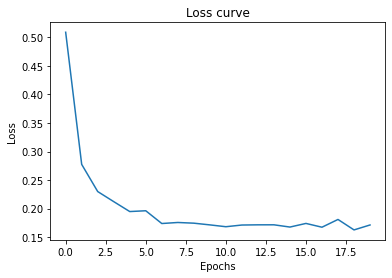

In [0]:
# Plot history
plt.title("Loss curve")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'], label = 'loss')
plt.show()

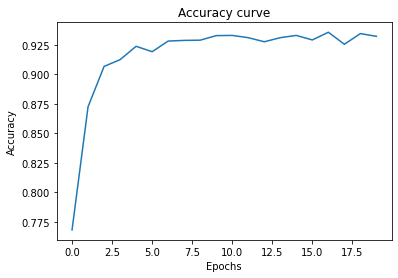

In [0]:
plt.title("Accuracy curve")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['accuracy'], label = 'accuracy')
plt.show()

In [0]:
result  = model.evaluate_generator(generator=test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

624/624 [==============================] - 13s 21ms/step
Loss: 0.18745583295822144
Accuracy: 0.8766025900840759


In [0]:
#acc, loss = model.evaluate(test_data, test_labels)
#print("Loss = %s, Mertrics = %s " % (acc, loss))

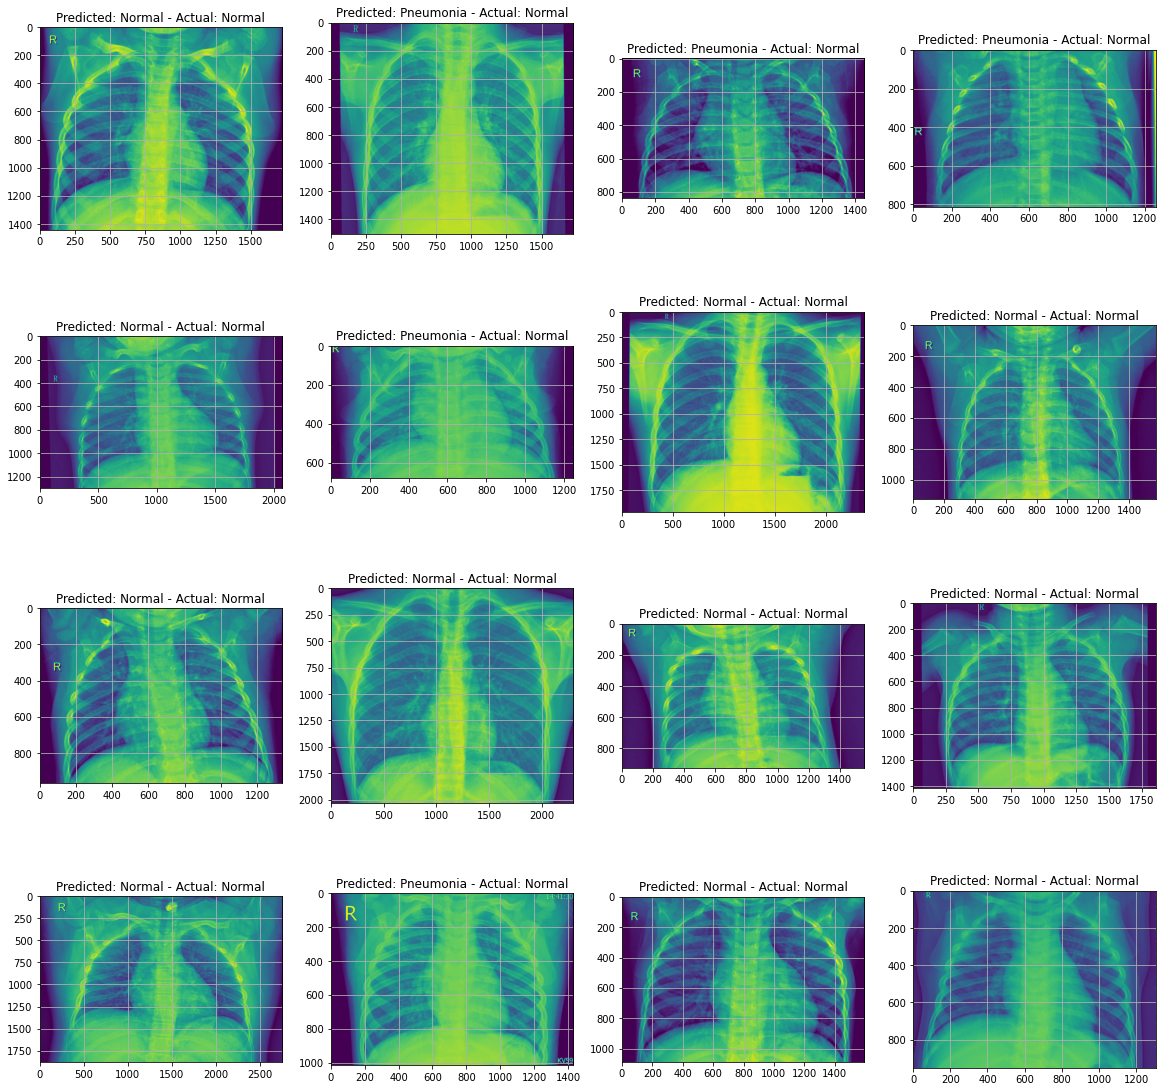

In [0]:
preds = model.predict([test_data])

preds = preds.squeeze()
preds = np.where(preds >= 0.5, 1, 0)

class_value = ["Normal", "Pneumonia"]
plt.figure(figsize=(20,20))
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.grid(True)
  im1 = plt.imread(path_images[i])
  #plt.imshow(im1)
  plt.title("Predicted: %s - Actual: %s" % (class_value[preds[i]], class_value[test_labels[i]]))
  plt.imshow(im1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


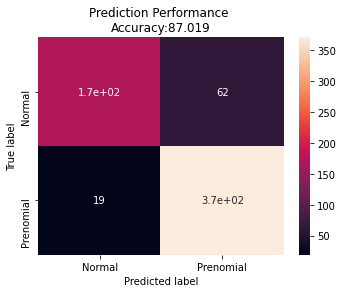


TEST METRICS ----------------------
Accuracy: 87.01923076923077%
Precision: 85.68129330254041%
Recall: 95.12820512820512%
F1-score: 90.15795868772783%

Overall view about metrics:
               precision    recall  f1-score   support

           0       0.90      0.74      0.81       234
           1       0.86      0.95      0.90       390

    accuracy                           0.87       624
   macro avg       0.88      0.84      0.86       624
weighted avg       0.87      0.87      0.87       624



In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

cm_df = pd.DataFrame(cm,
                     index = ['Normal','Prenomial'], 
                     columns = ['Normal','Prenomial'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Prediction Performance \nAccuracy:{0:.3f}'.format(acc))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}%'.format(2*precision*recall/(precision+recall)))

report = classification_report(test_labels, preds)
print("\nOverall view about metrics:\n", report)

In [0]:
model.save('Prenomial_Detection.h5')